In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
# sys.path.append('/home/jovyan/work/GitHub/EvanPys/Progress')
sys.path.append(r'C:\Users\evanlee\Documents\GitHub\EvanPys\Progress')
# sys.path.append('/Users/evanli/Documents/EvanPys/Progress')
from ADlasso2 import AD2_w_utils_lossdiff as ad

## Ignore section lambda decision
(Feature 數量為零之後的lambda就不要了)

In [2]:
os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_ztrans\Level2\tuning_result")

In [3]:
def ignore_section_lambda_decision(tuning_dict, celltype, start_idx=0, version='new', output_dir=''):
    if version == 'new':
        # convert tuning_dict to old format
        tuning_old_format = {}
        for outer_key in tuning_dict.keys():
            for inner_key, value in tuning_dict[outer_key].items():
                if inner_key not in tuning_old_format.keys():
                    tuning_old_format[inner_key] = []
                tuning_old_format[inner_key].append(value)
    else:
        tuning_old_format = tuning_dict

    for key in tuning_old_format.keys():
        tuning_old_format[key] = np.array(tuning_old_format[key])
    
    # start index should be the index of lambda at which the BCE curve does not look strange
    if start_idx > 0:
        print('Start index:', start_idx)
    # Find the index of feature_number start to become 0
    cut_idx = len(tuning_old_format['Feature_number'])
    for i in range(len(tuning_old_format['Feature_number'])):
        if tuning_old_format['Feature_number'][i] == 0:
            cut_idx = i
            print('Cut index:', cut_idx)
            break

    trimmed_tuning = {}
    for k in tuning_old_format.keys():
        trimmed_tuning[k] = tuning_old_format[k][start_idx:cut_idx]

    def plot_lambda_decision(tuning, celltype, opt_lmbd, cut_idx, start_idx=0, savepath=''):
        fig, ax1 = plt.subplots(figsize = (8, 5))
        ax2 = ax1.twinx()

        line1, = ax1.plot(np.exp(tuning['log_lambda_range']), tuning['loss_history'], marker='o', color='blue')
        line2, = ax2.plot(np.exp(tuning['log_lambda_range']), tuning['Feature_number'], marker='o', color='orange')
        ax1.set(xscale="log")

        # vertical line for optimal lambda
        plt.axvline(x=opt_lmbd, color = 'black', linestyle=':')
        
        # vertical line for start lambda (blue)
        if start_idx > 0:
            # only plot the start line when the start_idx is not the first index
            print('Start:', np.exp(tuning['log_lambda_range'][start_idx]))
            # vertical line for start lambda
            plt.axvline(x=np.exp(tuning['log_lambda_range'][start_idx]), color = 'blue', linestyle=':')
        # vertical line for cut lambda (red)
        if cut_idx < len(tuning['log_lambda_range']):
            # only plot the cut line when the cut_idx is not the last index
            print('Cut:', np.exp(tuning['log_lambda_range'][cut_idx]))
            # vertical line for cut lambda
            plt.axvline(x=np.exp(tuning['log_lambda_range'][cut_idx]), color = 'red', linestyle=':')
        
        # horizontal line for feature number = 0 (this does not make sense with y log scale)
        # plt.axhline(y=0, color = 'black', linestyle='--')

        ax1.set_xlabel(f"lambda (optimal: {opt_lmbd})")
        ax1.set_ylabel("Loss"); ax2.set_ylabel("Feature number")
        ax2.set_yscale("log")  # set log scale for feature number
        ax2.set_ylim(bottom=0.5, top=None)  # set ylim for feature number  # EDITTED
        ax1.set_title(f'{celltype} lambda decision')
        plt.legend(handles=[line1, line2], labels=['BCE loss', 'Feature_number'], loc='upper left')

        if savepath:
            plt.savefig(savepath, dpi=300)

    # Lambda decision from trimmed tuning result
    # TODO: reset k value of lambda decision
    opt_lmbd, fig = ad.lambda_decision(trimmed_tuning, k=2, savepath=output_dir + f'{celltype}_lambda_decision_trimmed.png')
    print('Optimal lambda:', opt_lmbd)
    log_opt_lmbd = np.log(opt_lmbd)

    log_lambda_range = tuning_old_format['log_lambda_range']
    opt_idx = np.where(log_lambda_range == log_opt_lmbd)[0][0]

    feature_no_celltype = int(tuning_old_format['Feature_number'][opt_idx])
    print('Feature no:', feature_no_celltype)

    # Plot lambda vs. prevalence and lambda vs. loss
    plot_lambda_decision(tuning_old_format, celltype, opt_lmbd, cut_idx, start_idx=start_idx, savepath=output_dir + f'{celltype}_lambda_decision_all.png')

    return opt_lmbd, feature_no_celltype

In [5]:
import scanpy as sc
adata = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\PBMC_Hao\GSE164378_Hao\Harmony_and_ztrans\Hao_L2_repcells_loginv_Harmony_ztrans.h5ad")
print('Original adata:', adata.shape, type(adata.X))
label = adata.obs['celltype.l2'].tolist()
types = np.unique(label).tolist()
print('all cell types:', types)


Original adata: (57515, 27504) <class 'numpy.ndarray'>
all cell types: ['ASDC', 'B_intermediate', 'B_memory', 'B_naive', 'CD14_Mono', 'CD16_Mono', 'CD4_CTL', 'CD4_Naive', 'CD4_Proliferating', 'CD4_TCM', 'CD4_TEM', 'CD8_Naive', 'CD8_Proliferating', 'CD8_TCM', 'CD8_TEM', 'Doublet', 'Eryth', 'HSPC', 'ILC', 'MAIT', 'NK', 'NK_CD56bright', 'NK_Proliferating', 'Plasmablast', 'Platelet', 'Treg', 'cDC1', 'cDC2', 'dnT', 'gdT', 'pDC']


In [6]:
opt_lmbd_dict = {}
feature_no_dict = {}

In [7]:
# queue = ['ASDC', 'CD4_Proliferating', 'CD8_Proliferating', 'Eryth', 'ILC']  # RCT
queue = types

In [8]:
### Function for running lambda decision for a single cell types
def run_lmbd_decision(celltype, start_idx=0, output_dir=''):
    tuning_file = f'{celltype}_tuning.json'
    if not os.path.exists(tuning_file):
        print(f"File {tuning_file} does not exist. Skipping to the next cluster.")
        return

    print('====================')
    print(f'Cell type: {celltype}')
    with open(tuning_file) as f:
        tuning = json.load(f)

    opt_lmbd, feature_no_celltype = ignore_section_lambda_decision(tuning, celltype, start_idx=start_idx, version='old', output_dir=output_dir)
    opt_lmbd_dict[celltype] = opt_lmbd
    feature_no_dict[celltype] = feature_no_celltype

ASDC 0
Cell type: ASDC
Cut index: 24
Optimal lambda: 2.1544346900318854e-05
Feature no: 10630
Cut: 0.10000000000000002
B_intermediate 0
Cell type: B_intermediate
Cut index: 24
Optimal lambda: 0.0316227766016838
Feature no: 15
Cut: 0.10000000000000002
B_memory 0
Cell type: B_memory
Cut index: 24
Optimal lambda: 0.0316227766016838
Feature no: 18
Cut: 0.10000000000000002
B_naive 0
Cell type: B_naive
Optimal lambda: 0.00046415888336127795
Feature no: 683
CD14_Mono 0
Cell type: CD14_Mono
Optimal lambda: 0.014677992676220709
Feature no: 20
CD16_Mono 0
Cell type: CD16_Mono
Optimal lambda: 0.006812920690579613
Feature no: 104
CD4_CTL 0
Cell type: CD4_CTL
Cut index: 24
Optimal lambda: 0.0316227766016838
Feature no: 18
Cut: 0.10000000000000002
CD4_Naive 0
Cell type: CD4_Naive
Optimal lambda: 0.04641588833612786
Feature no: 12
CD4_Proliferating 0
Cell type: CD4_Proliferating
Cut index: 24
Optimal lambda: 0.0010000000000000002
Feature no: 2303
Cut: 0.10000000000000002
CD4_TCM 0
Cell type: CD4_TCM


C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\ADlasso2\AD2_w_utils_lossdiff.py:975: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax1 = plt.subplots(figsize = (fig_width, fig_height))


Optimal lambda: 0.0002154434690031884
Feature no: 3333
Cut: 0.10000000000000002
CD8_Naive 0
Cell type: CD8_Naive
Cut index: 24
Optimal lambda: 0.003162277660168382
Feature no: 234
Cut: 0.10000000000000002
CD8_Proliferating 0
Cell type: CD8_Proliferating
Cut index: 24
Optimal lambda: 0.0006812920690579617
Feature no: 2492
Cut: 0.10000000000000002
CD8_TCM 0
Cell type: CD8_TCM
Cut index: 24
Optimal lambda: 0.0002154434690031884
Feature no: 3479
Cut: 0.10000000000000002
CD8_TEM 0
Cell type: CD8_TEM
Cut index: 24
Optimal lambda: 0.004641588833612781
Feature no: 156
Cut: 0.10000000000000002
Doublet 0
Cell type: Doublet
Optimal lambda: 0.04641588833612786
Feature no: 12
Eryth 0
Cell type: Eryth
Cut index: 24
Optimal lambda: 2.1544346900318854e-05
Feature no: 8483
Cut: 0.10000000000000002
HSPC 0
Cell type: HSPC
Cut index: 24
Optimal lambda: 6.81292069057961e-05
Feature no: 5249
Cut: 0.10000000000000002
ILC 0
Cell type: ILC
Cut index: 24
Optimal lambda: 0.0002154434690031884
Feature no: 3257
Cu

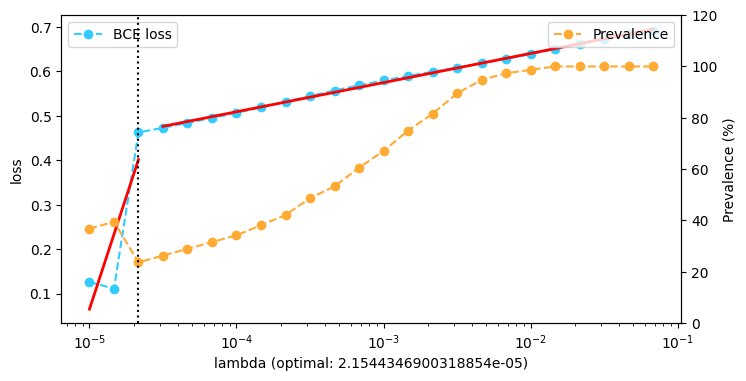

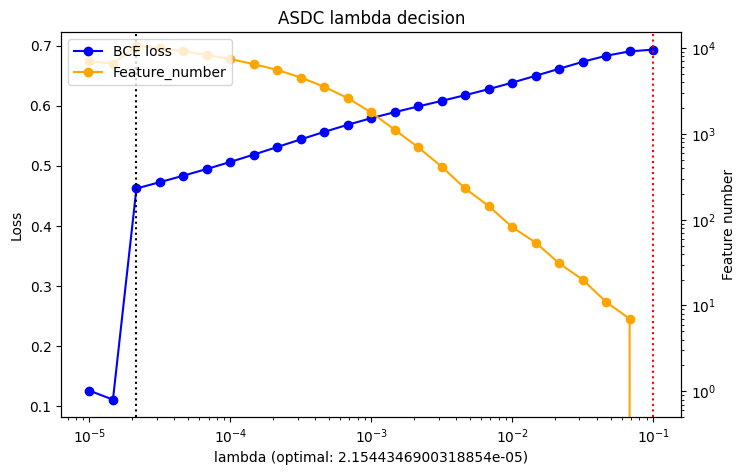

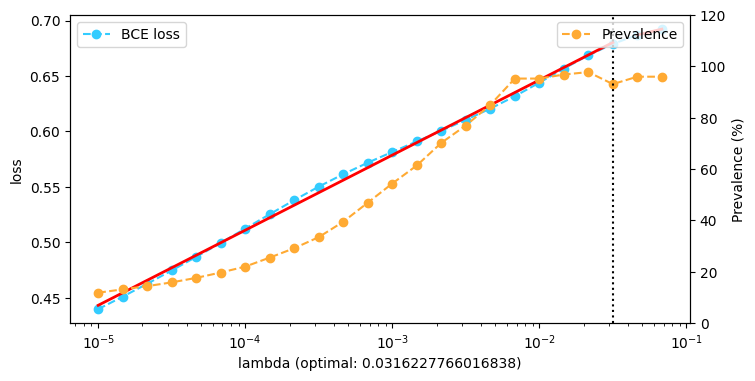

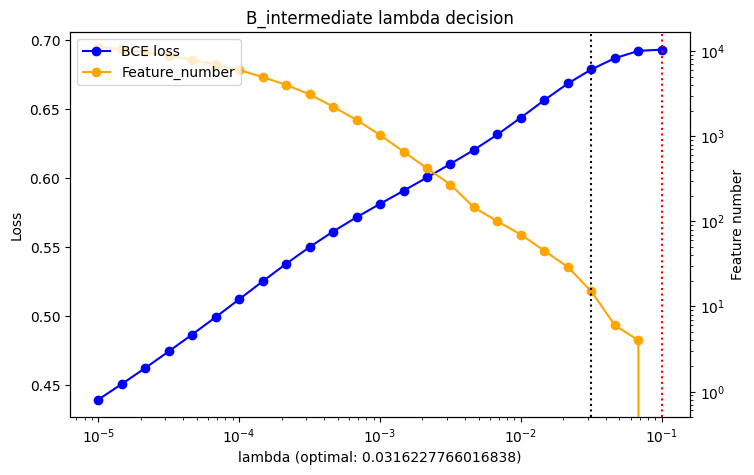

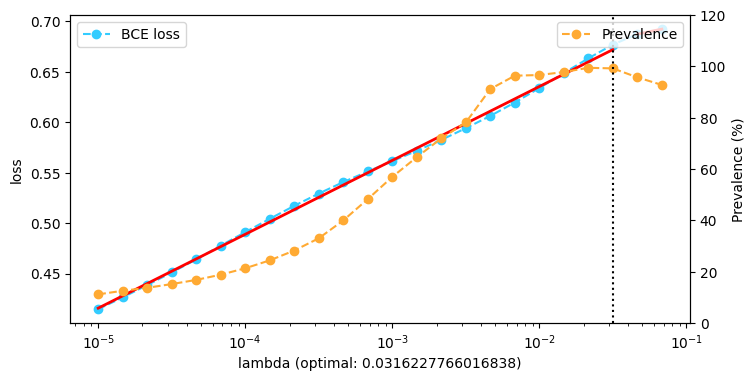

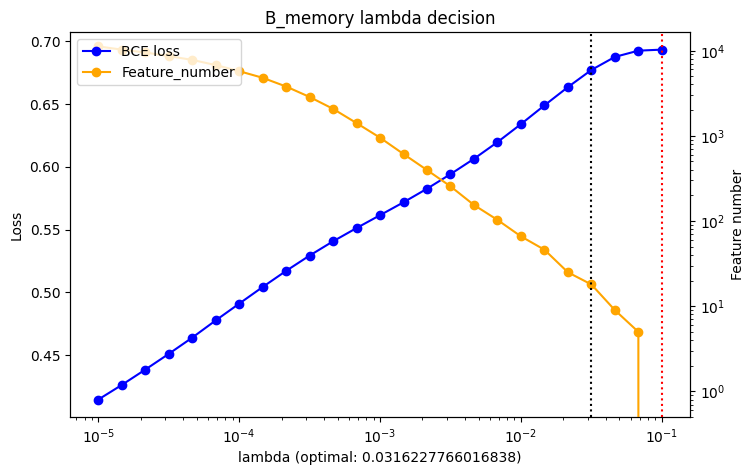

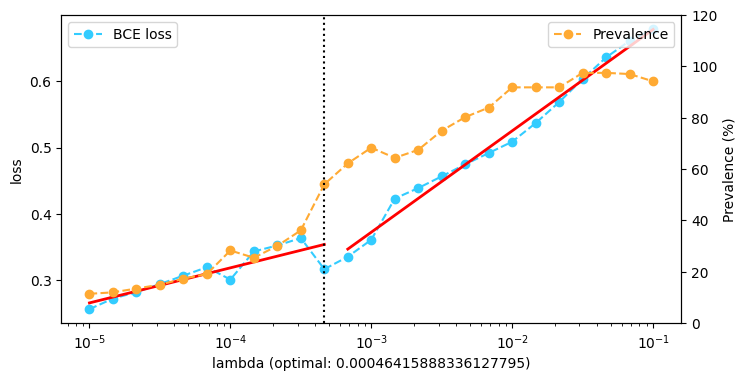

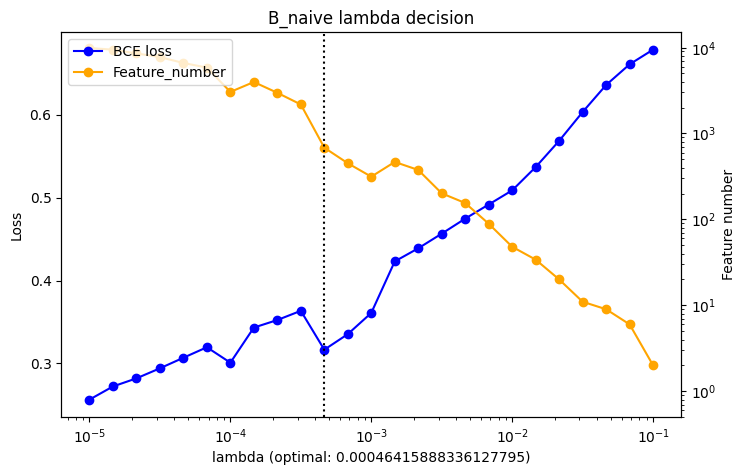

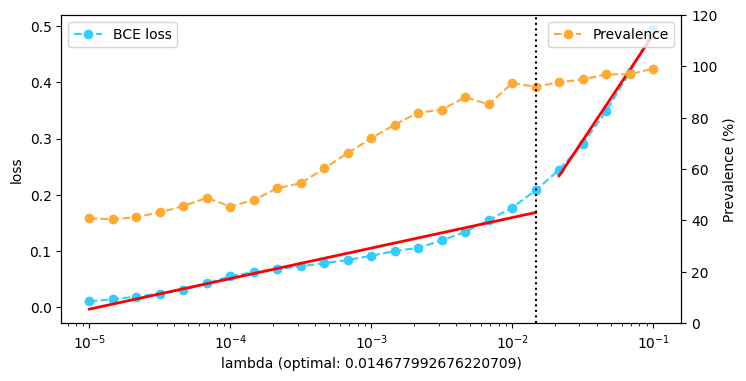

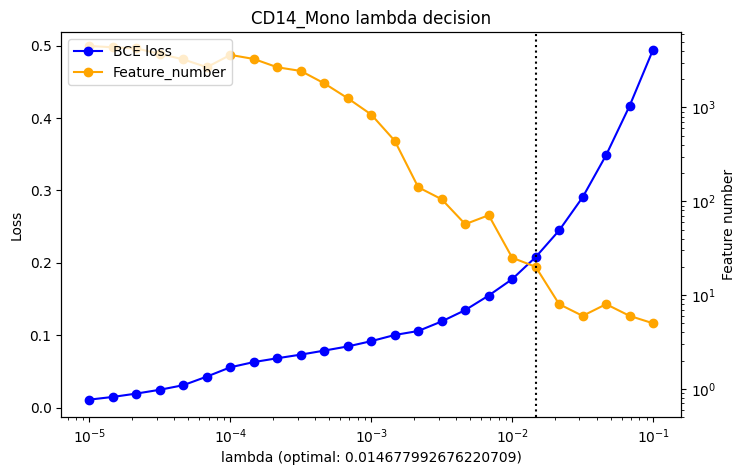

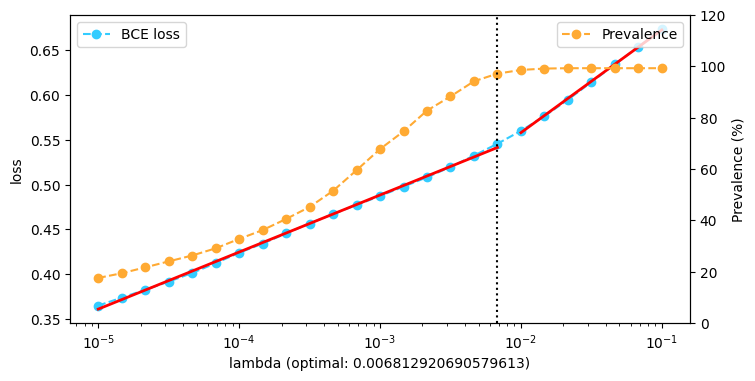

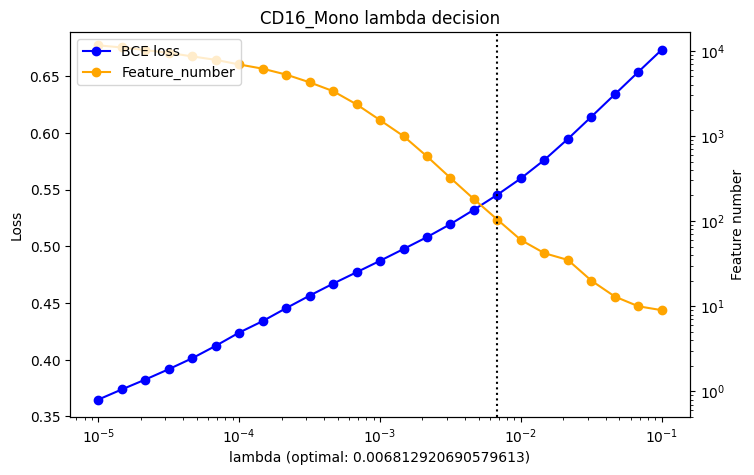

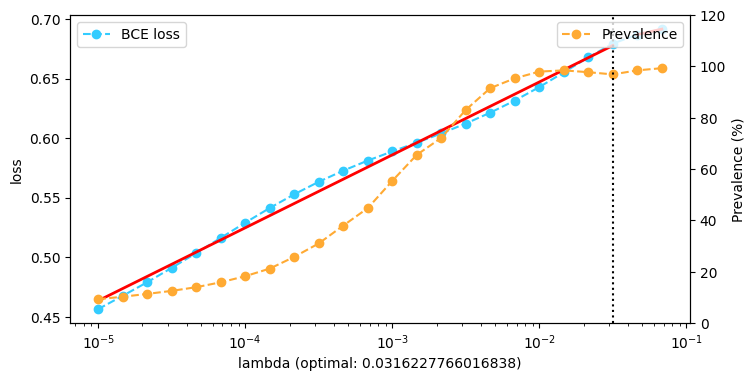

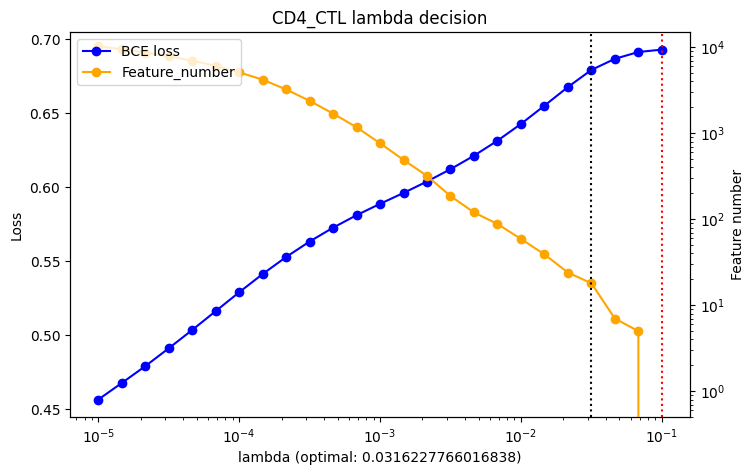

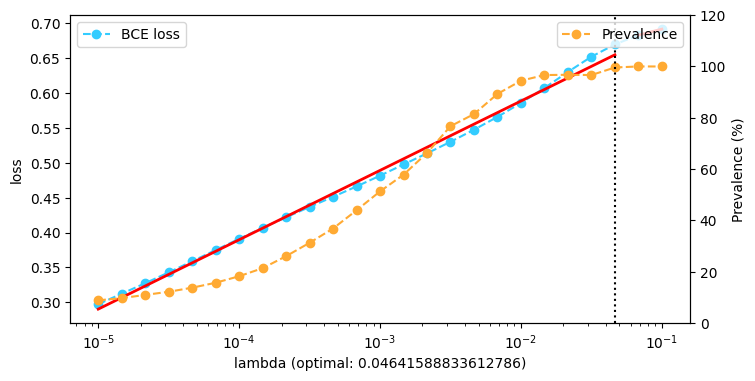

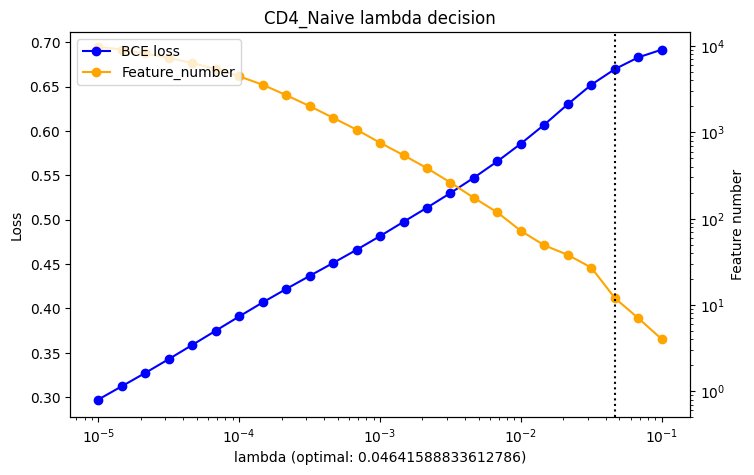

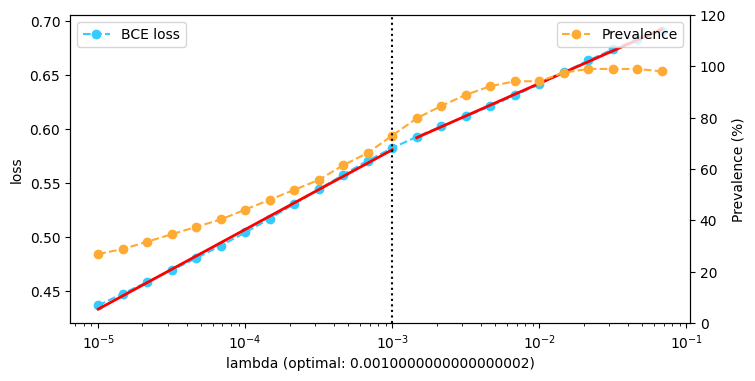

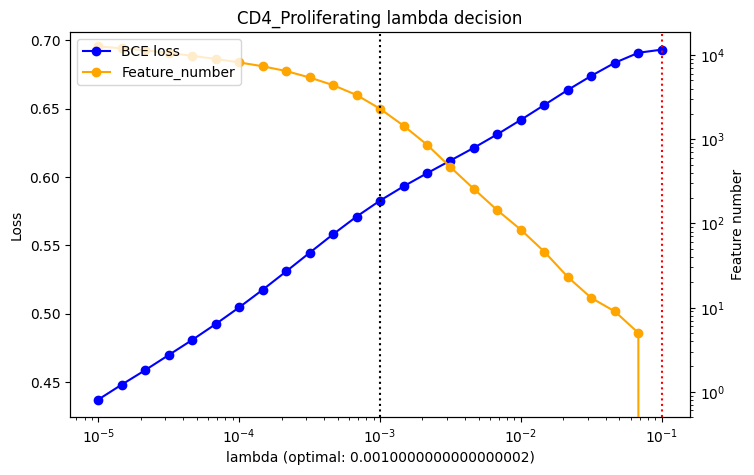

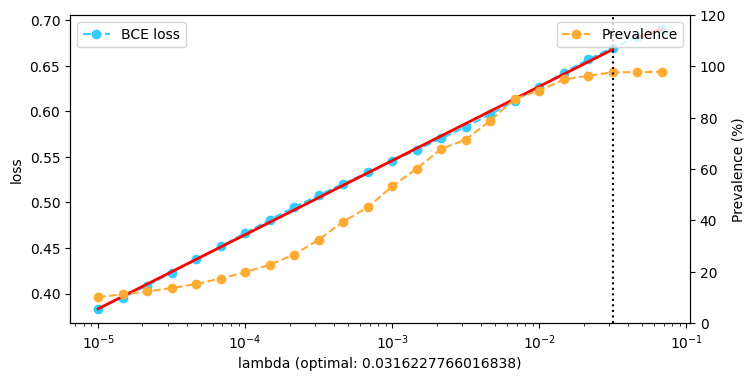

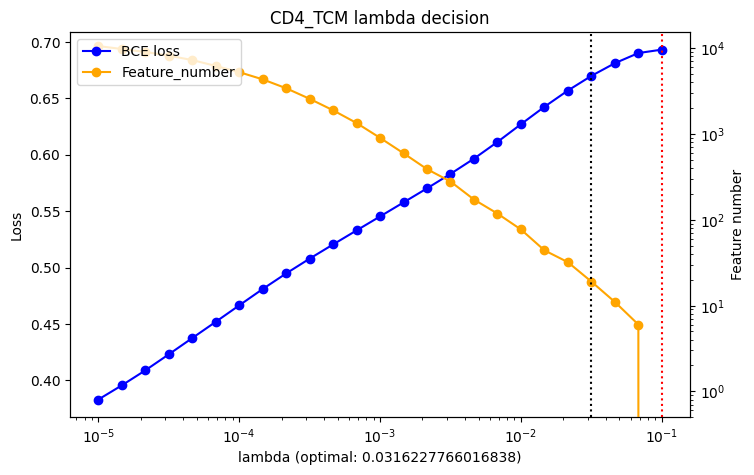

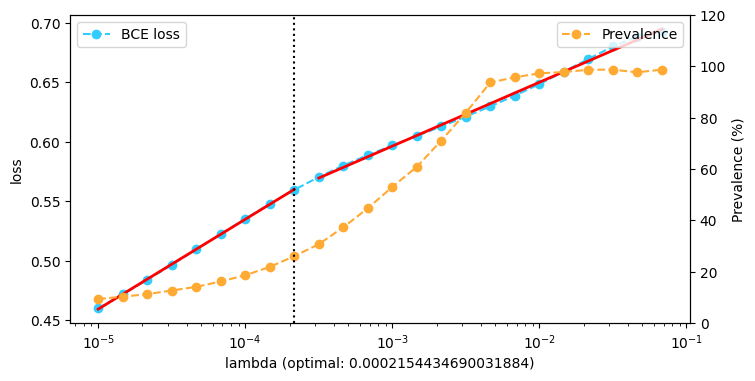

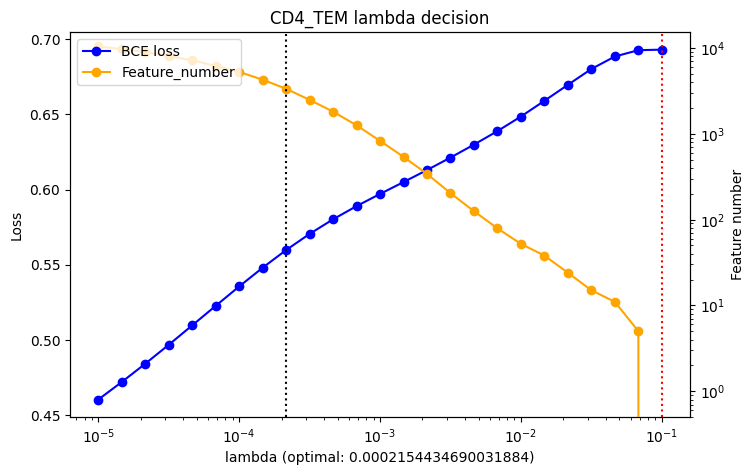

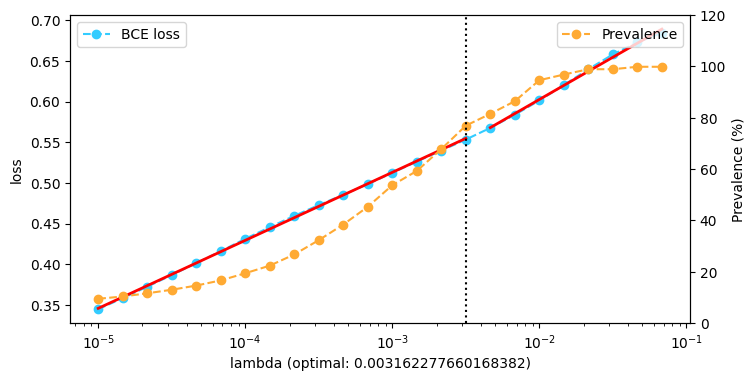

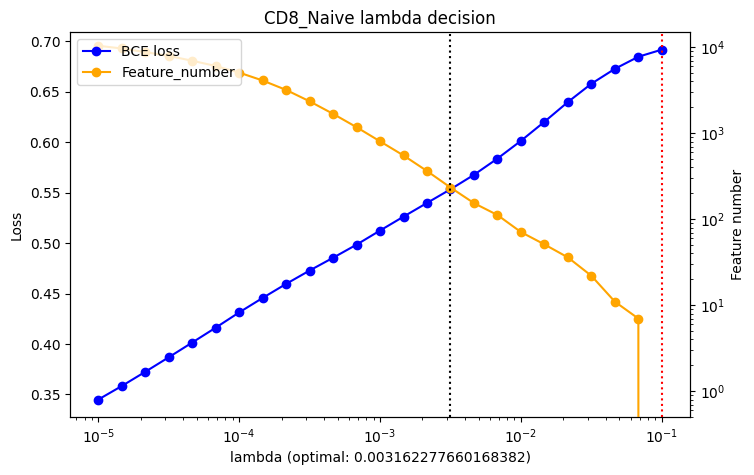

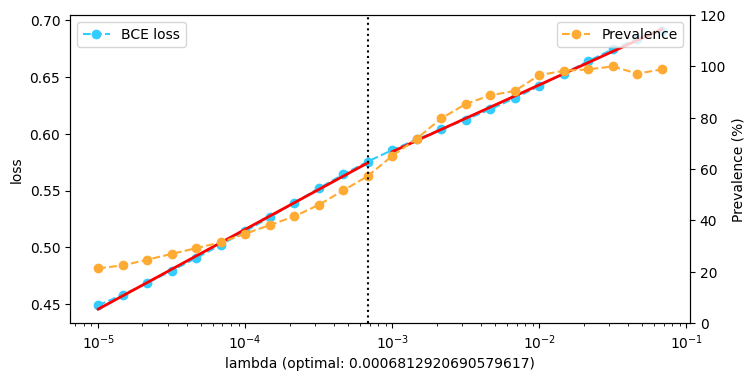

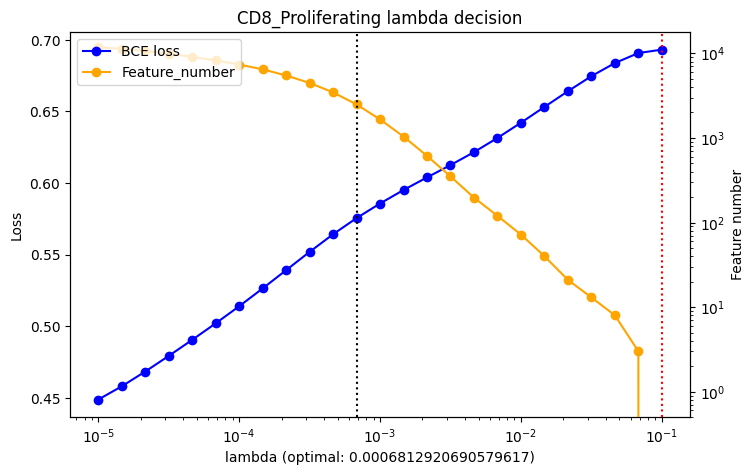

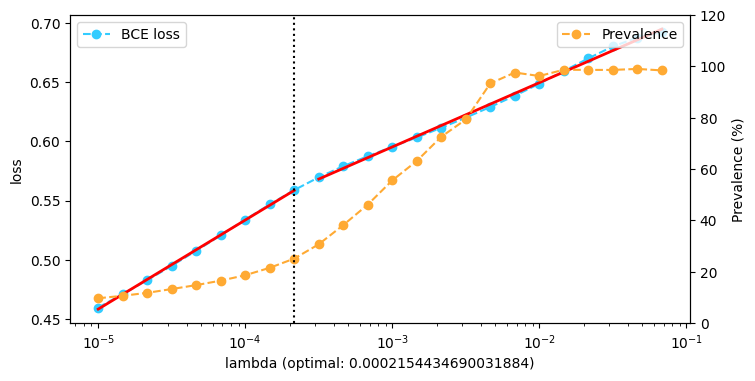

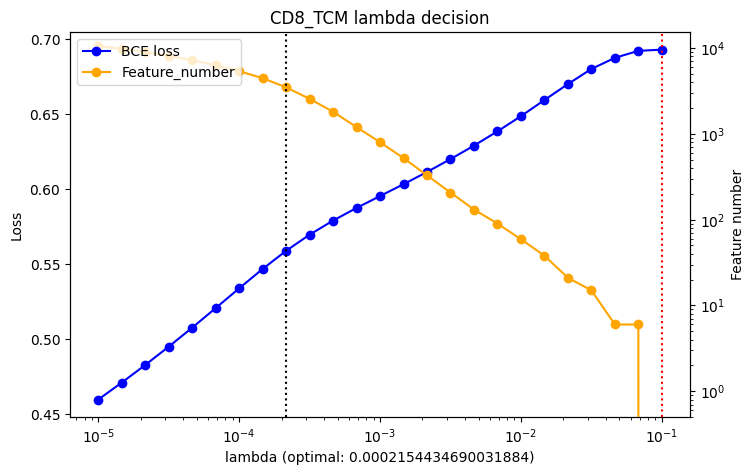

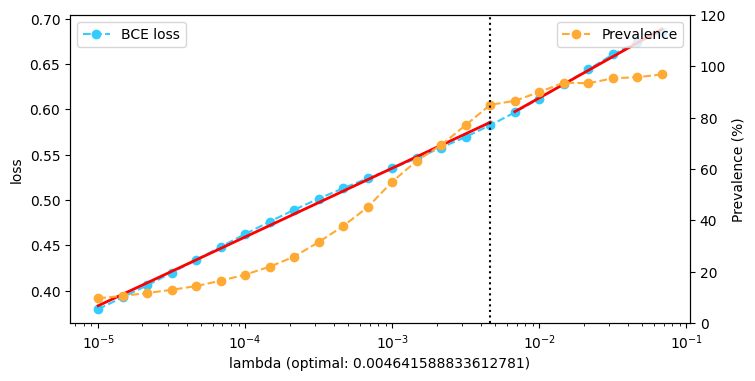

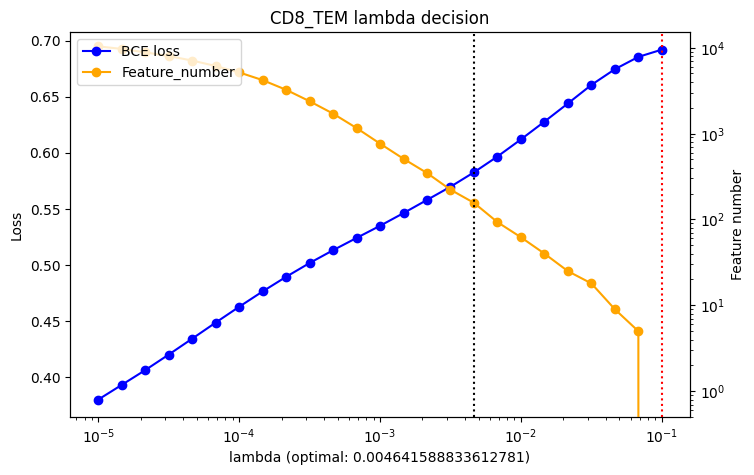

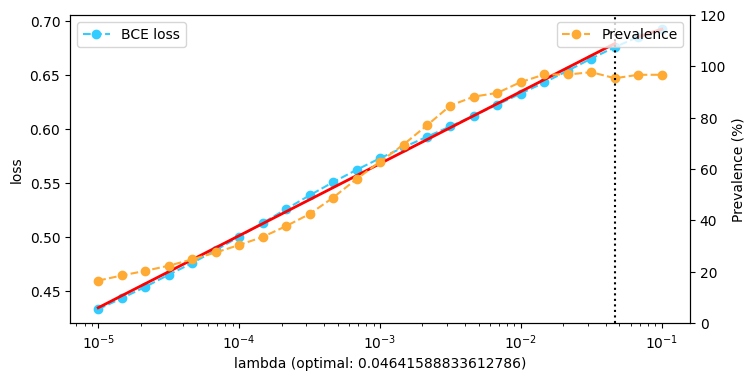

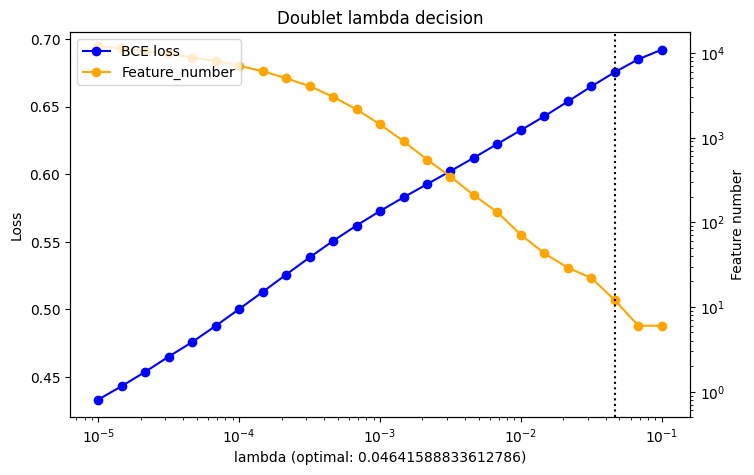

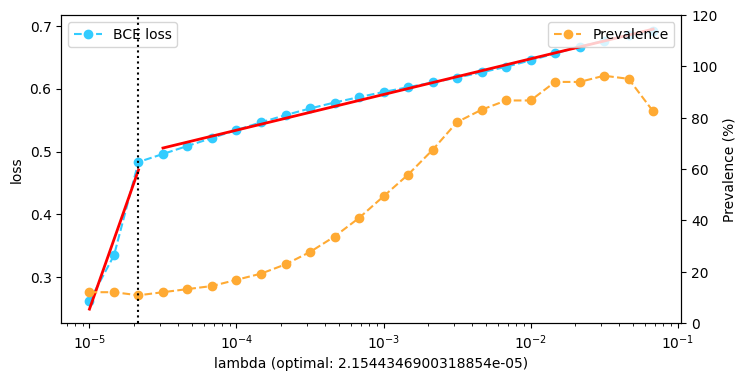

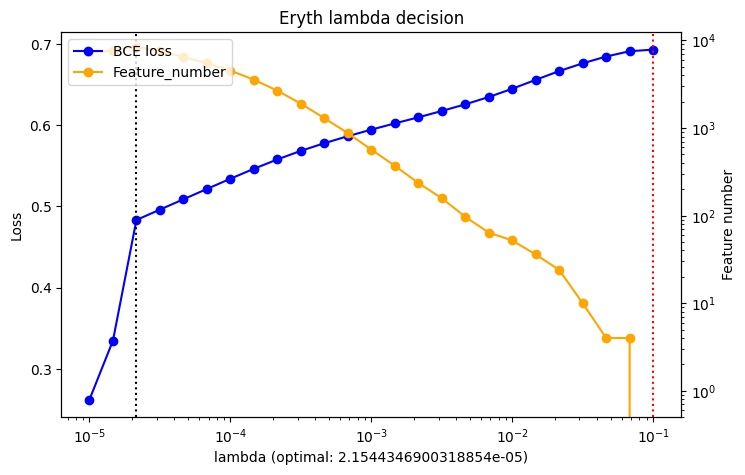

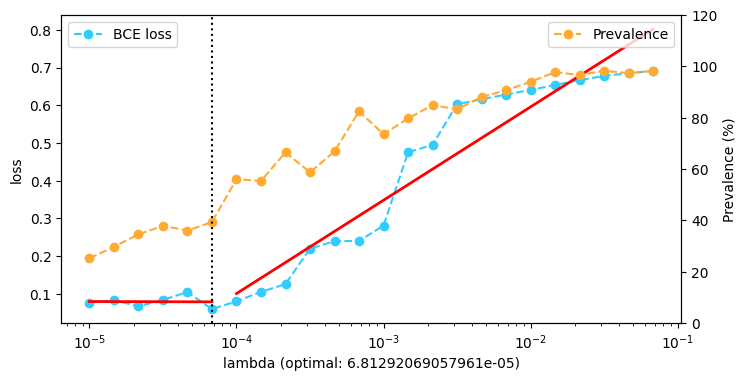

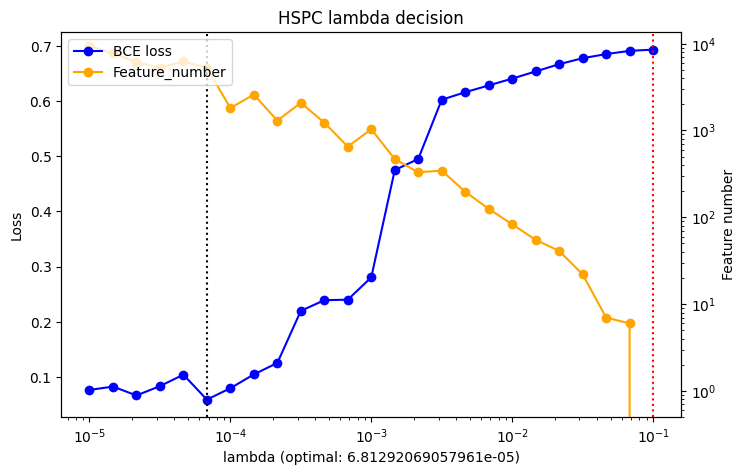

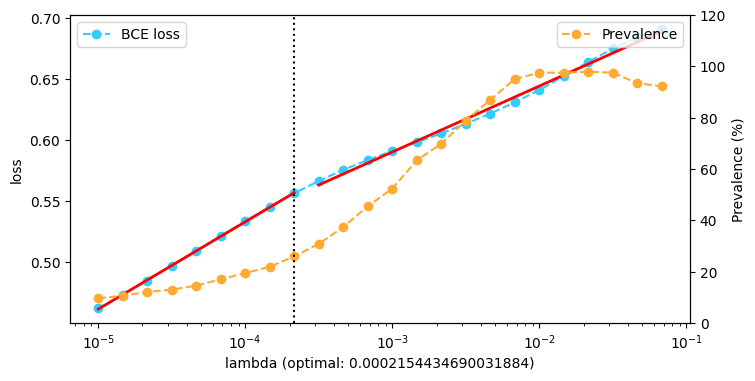

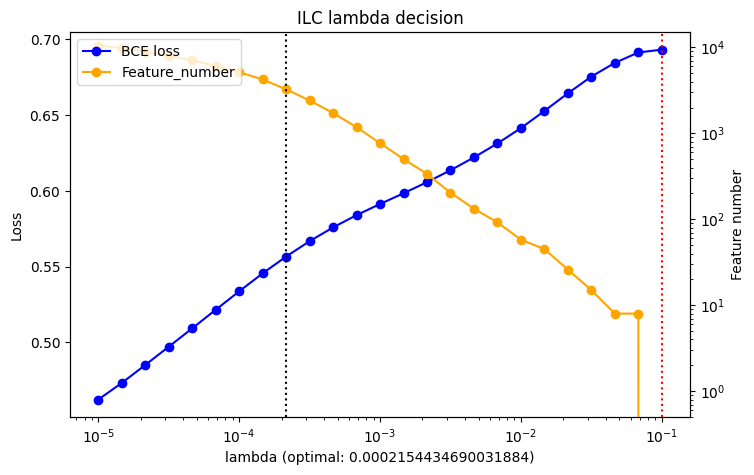

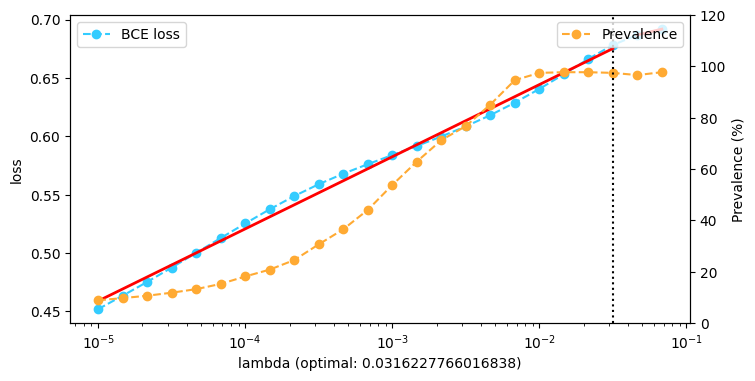

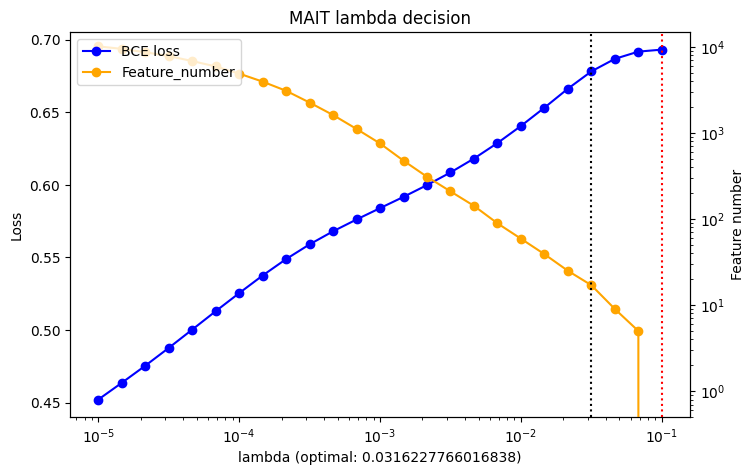

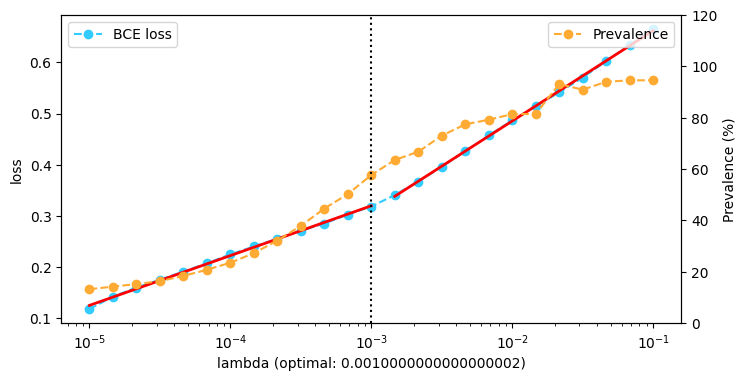

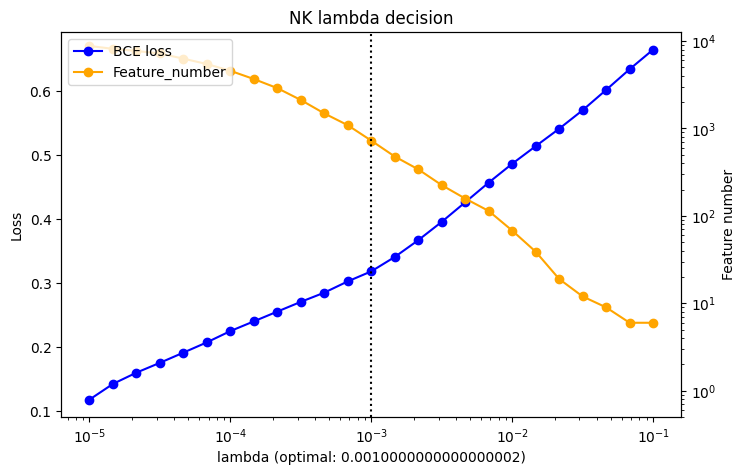

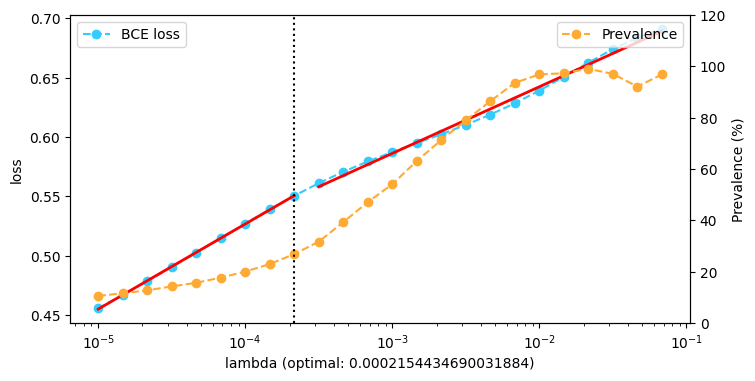

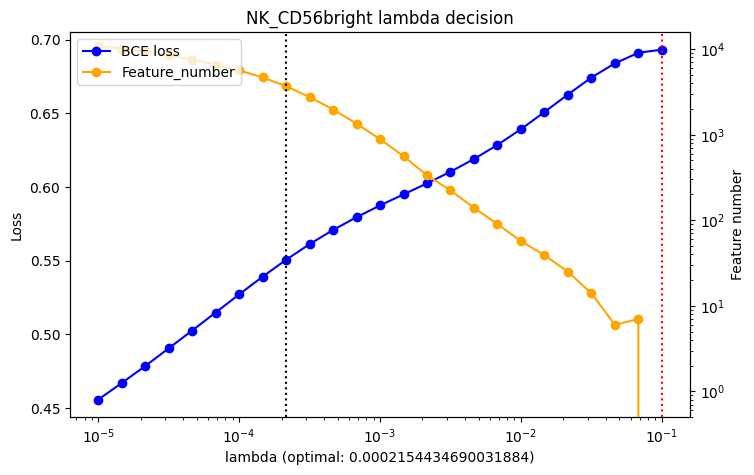

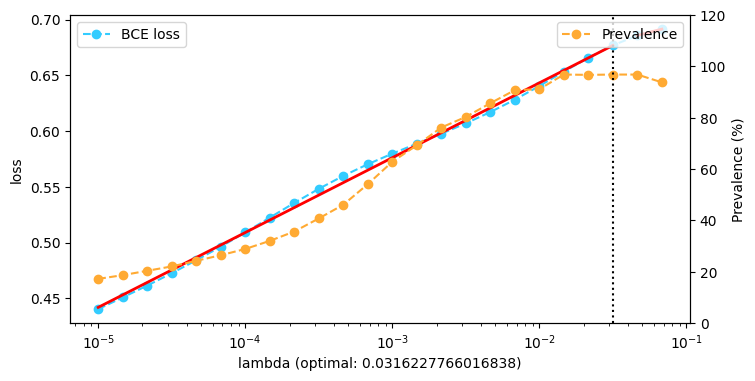

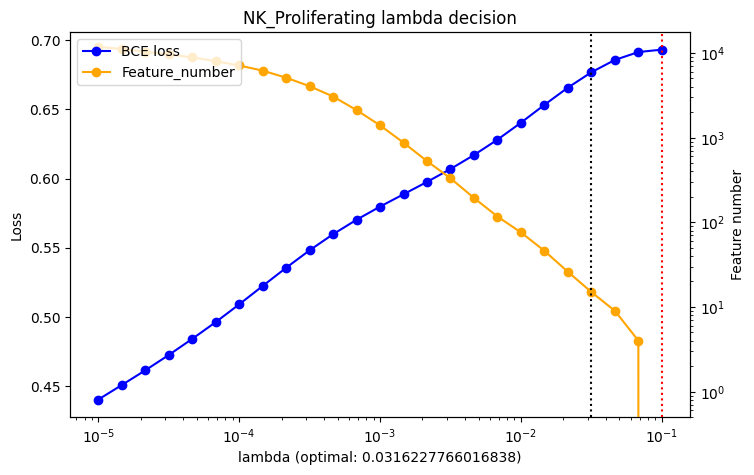

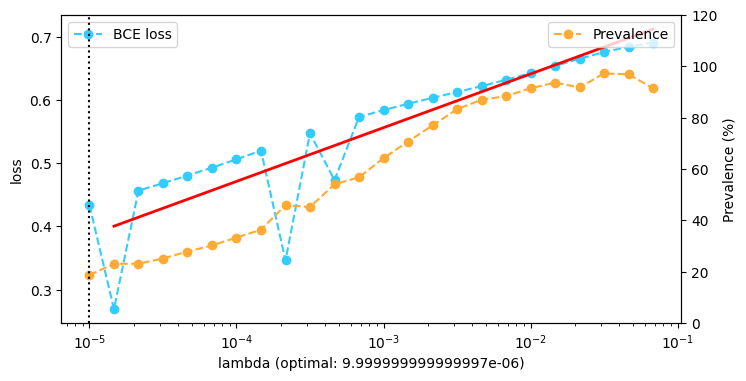

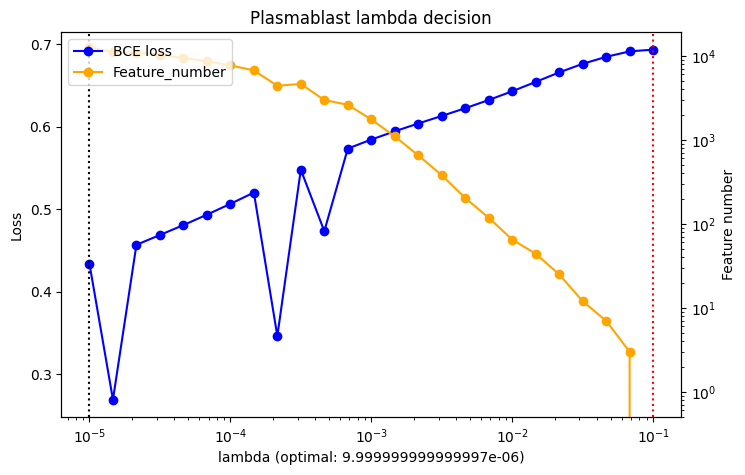

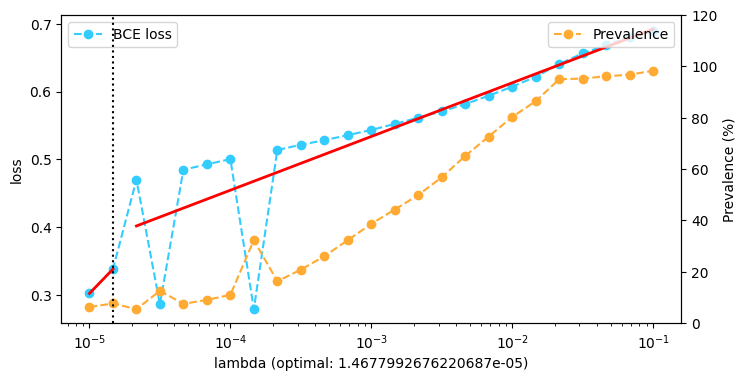

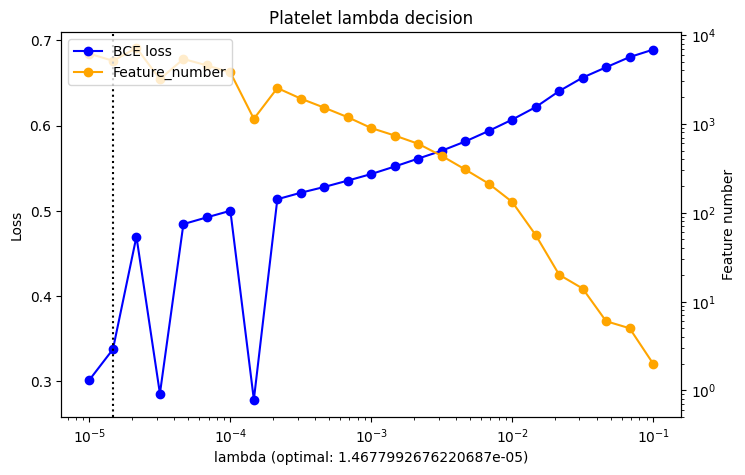

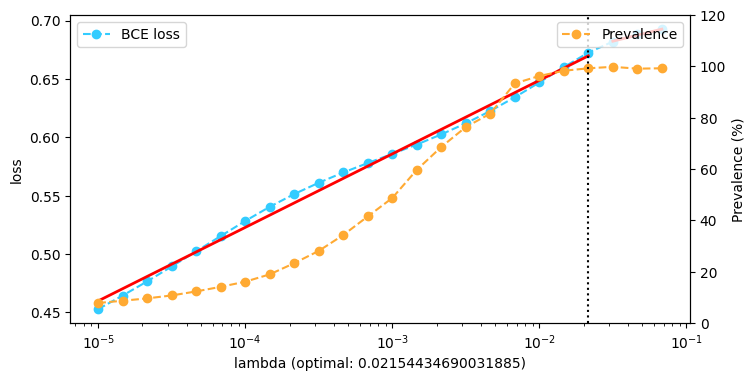

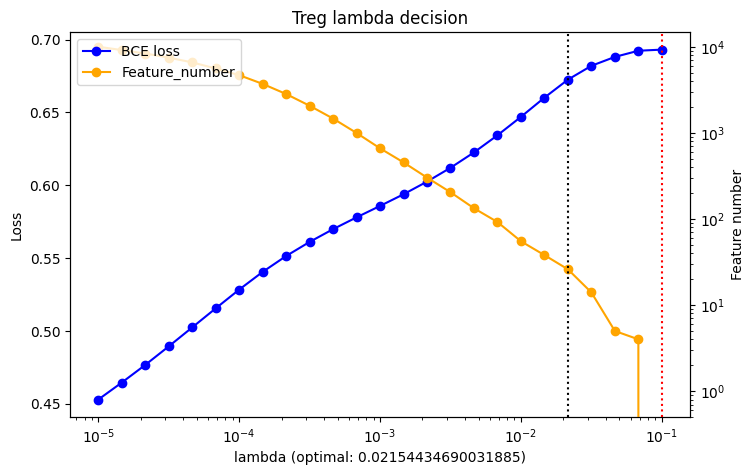

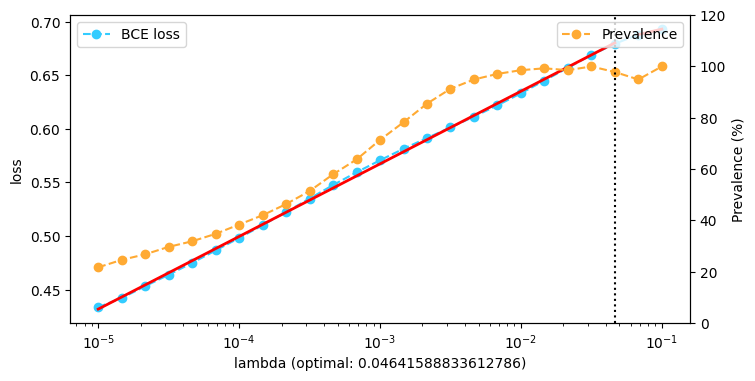

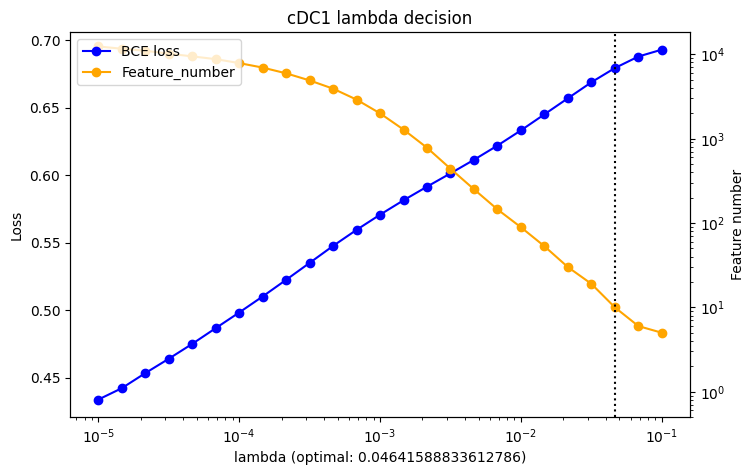

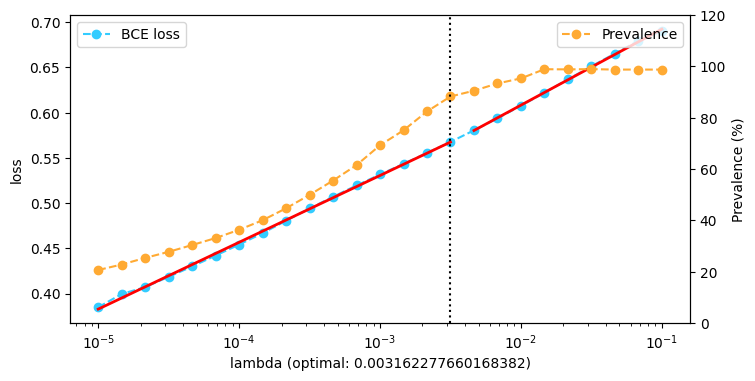

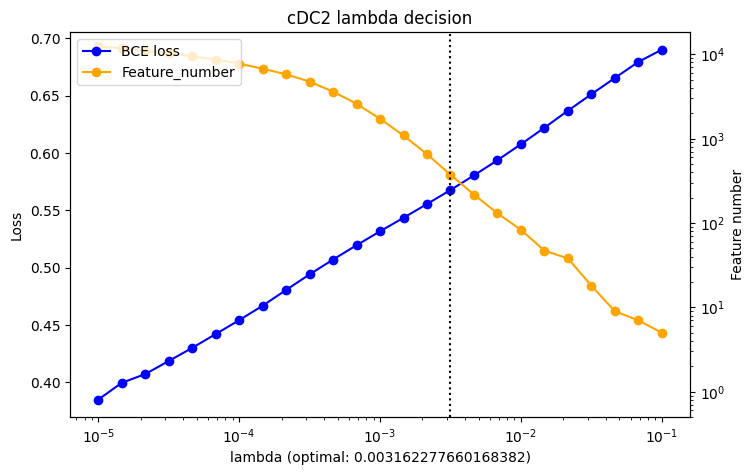

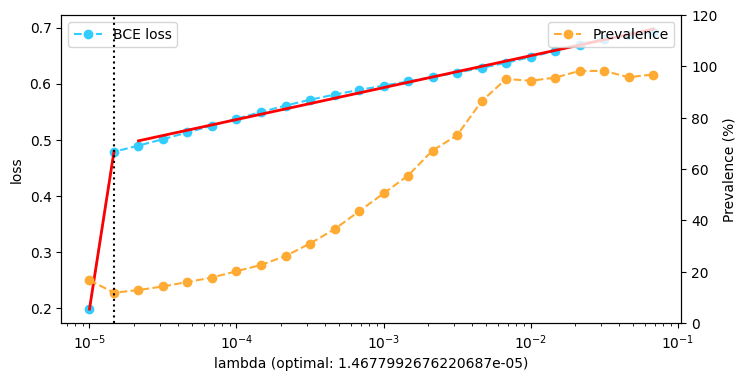

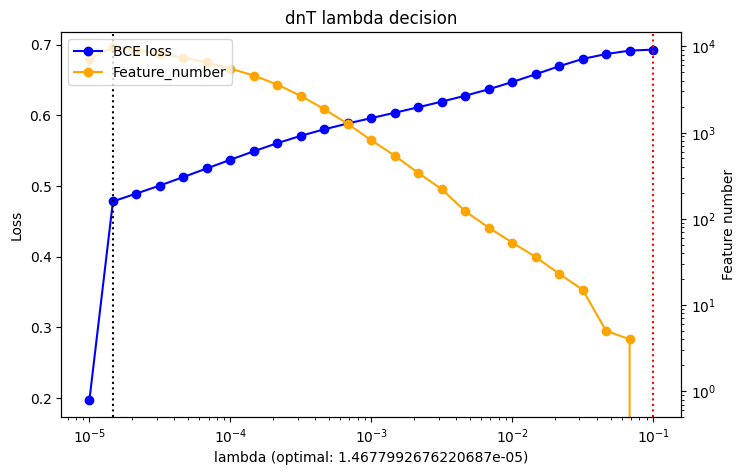

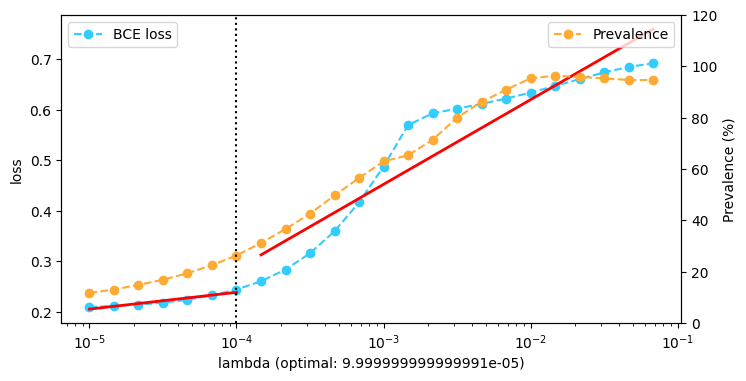

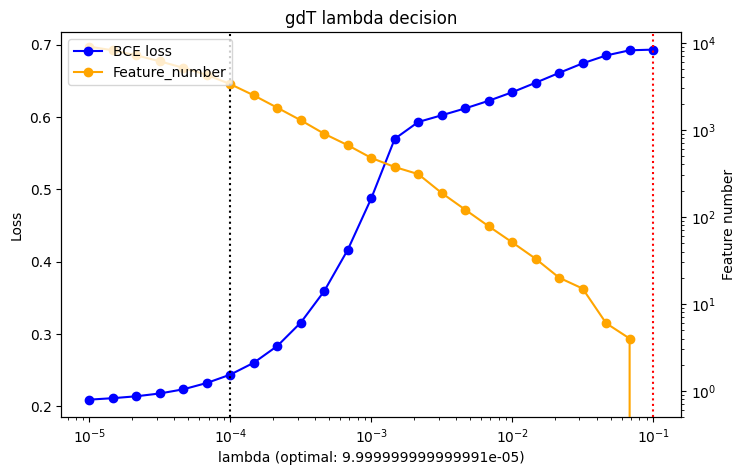

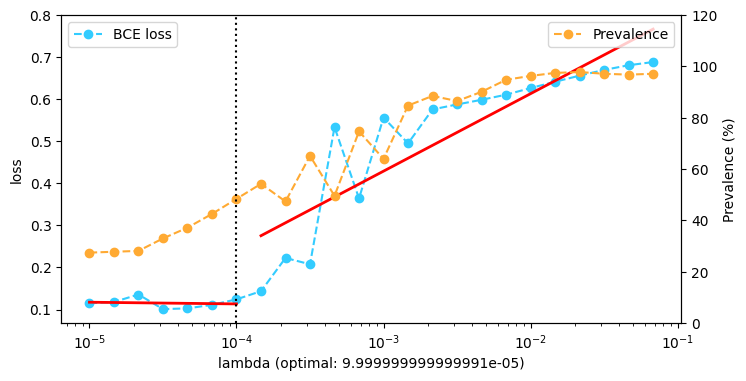

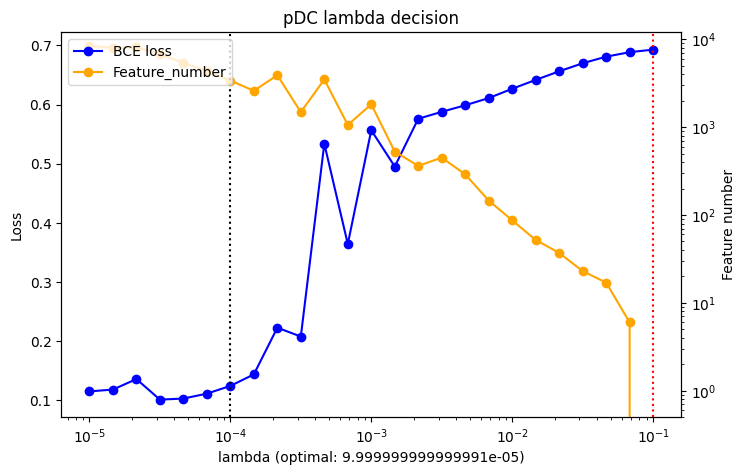

In [10]:
# Start index for each cell type
start_idx_dict = {}
# start_idx_dict = {
#     'ASDC': 4,
#     'CD4_Proliferating': 2,
#     'CD8_Proliferating': 3,
#     'Eryth': 3,
#     'ILC': 1
# }

dir = r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_ztrans\Level2\lambda_decision" + '\\'
for celltype in queue:
    start_idx = start_idx_dict.get(celltype, 0)
    print('====================')
    print(celltype, start_idx)
    run_lmbd_decision(celltype, start_idx=start_idx, output_dir=dir)

In [11]:
opt_lmbd_dict

{'ASDC': 2.1544346900318854e-05,
 'B_intermediate': 0.0316227766016838,
 'B_memory': 0.0316227766016838,
 'B_naive': 0.00046415888336127795,
 'CD14_Mono': 0.014677992676220709,
 'CD16_Mono': 0.006812920690579613,
 'CD4_CTL': 0.0316227766016838,
 'CD4_Naive': 0.04641588833612786,
 'CD4_Proliferating': 0.0010000000000000002,
 'CD4_TCM': 0.0316227766016838,
 'CD4_TEM': 0.0002154434690031884,
 'CD8_Naive': 0.003162277660168382,
 'CD8_Proliferating': 0.0006812920690579617,
 'CD8_TCM': 0.0002154434690031884,
 'CD8_TEM': 0.004641588833612781,
 'Doublet': 0.04641588833612786,
 'Eryth': 2.1544346900318854e-05,
 'HSPC': 6.81292069057961e-05,
 'ILC': 0.0002154434690031884,
 'MAIT': 0.0316227766016838,
 'NK': 0.0010000000000000002,
 'NK_CD56bright': 0.0002154434690031884,
 'NK_Proliferating': 0.0316227766016838,
 'Plasmablast': 9.999999999999997e-06,
 'Platelet': 1.4677992676220687e-05,
 'Treg': 0.02154434690031885,
 'cDC1': 0.04641588833612786,
 'cDC2': 0.003162277660168382,
 'dnT': 1.46779926762

In [12]:
feature_no_dict

{'ASDC': 10630,
 'B_intermediate': 15,
 'B_memory': 18,
 'B_naive': 683,
 'CD14_Mono': 20,
 'CD16_Mono': 104,
 'CD4_CTL': 18,
 'CD4_Naive': 12,
 'CD4_Proliferating': 2303,
 'CD4_TCM': 19,
 'CD4_TEM': 3333,
 'CD8_Naive': 234,
 'CD8_Proliferating': 2492,
 'CD8_TCM': 3479,
 'CD8_TEM': 156,
 'Doublet': 12,
 'Eryth': 8483,
 'HSPC': 5249,
 'ILC': 3257,
 'MAIT': 17,
 'NK': 726,
 'NK_CD56bright': 3680,
 'NK_Proliferating': 15,
 'Plasmablast': 12613,
 'Platelet': 5107,
 'Treg': 26,
 'cDC1': 10,
 'cDC2': 372,
 'dnT': 9884,
 'gdT': 3351,
 'pDC': 3394}

In [13]:
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch/Level2_log_inv/opt_lambda_json')
with open('L2_Harmony_opt_lmbd_v3.json', 'w') as f:
    json.dump(opt_lmbd_dict, f)